# Workshop 5 – Vector Data Fundamentals in Python  
*Master’s in Geomatics*  
**Date:** 05 May 2025

This notebook expands your initial *Workshop5_draft.ipynb*.  
It follows **[Geocomputation with Python – Chapter 1: Spatial Data](https://py.geocompx.org/01-spatial-data.html)** and **[Chapter 2: Attribute Operations](https://py.geocompx.org/02-attribute-operations.html)**.

We work with Colombian municipal polygons stored in **EPSG 3116 (MAGNA‑SIRGAS / Colombia Bogotá)**, which uses **metres** – perfect for distance and area analysis.  


## Learning objectives  
After completing this workshop you will be able to  

1. Describe `GeoDataFrame`, `GeoSeries`, and **Shapely** geometries.  
2. Inspect, measure, and transform vector data in a metric CRS.  
3. Manipulate attributes with pandas/GeoPandas (selection, aggregation, joins).  
4. Join a non‑spatial agricultural table to a spatial layer.  
5. Dissolve polygons to summarise at regional level.  
6. Produce publication‑ready maps in Python.

*All text uses British English spelling.*  


---

## 1  Setting the scene

### 1.1. **Import** the core libraries.

In [32]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as cx
from pathlib import Path

### 1.2. Define data paths, and read the municipal shapefile and agricultural CSV.


| Step | What happens? | Key function / property |
|------|---------------|-------------------------|
| **1&nbsp;️&nbsp;Define `root_folder`** | Sets a *base directory* that stores all the workshop material on your computer. Change this string if your files live elsewhere. | *Plain Python string* |
| **2&nbsp;️&nbsp;Build file paths** – `shp_path`, `csv_path` | Concatenates the base directory with each filename. The **raw-string prefix `r"…"``** avoids back-slash issues under Windows. | String concatenation |
| **3&nbsp;️&nbsp;Read the shapefile** – `df_municipios = gpd.read_file(shp_path)` | Loads **`municipios_colombia.shp`** (plus its `.dbf`, `.shx`, `.prj` companions) into a GeoDataFrame. | `geopandas.read_file()` |
| **4&nbsp;️&nbsp;Create a second GeoDataFrame `muni`** | Re-opens the same shapefile so we can keep an untouched copy or experiment independently. | `geopandas.read_file()` |
| **5&nbsp;️&nbsp;Print the CRS** – `print("CRS:", muni.crs)` | Confirms the layer’s Coordinate Reference System. It should report **EPSG 3116 – MAGNA-SIRGAS / Colombia Bogotá** (units: metres). | `GeoDataFrame.crs` |
| **6&nbsp;️&nbsp;Inspect the schema** – `muni.info()` | Shows a tidy summary: number of rows, data types, and non-null counts for every column. Useful for quick QA. | `GeoDataFrame.info()` |
| **7&nbsp&nbsp;Preview the first rows** – `muni.head()` | Prints the first five records so you can spot-check attribute names and typical values. | `GeoDataFrame.head()` |

> **Note:** The path for the EVA table (`csv_path`) is defined here but **not** read yet—we will load it later when demonstrating attribute joins.

If you encounter “file not found” errors, double-check that **`root_folder`** reflects the actual folder structure on *your* machine and that filenames (including capitalisation) are correct.

In [109]:
root_folder=r"C:\Users/Liliana/OneDrive - Universidad Nacional de Colombia/1_Periodos_Asignaturas/Cursos_2025_1/Programacion SIG/Talleres"
shp_path=root_folder+r"/municipios_colombia.shp"
df_municipios = gpd.read_file(shp_path)
csv_path  = root_folder+"/Evaluaciones_Agropecuarias_Municipales_EVA.csv"

muni = gpd.read_file(shp_path)
print("CRS:", muni.crs)              
muni.info()
print(muni.head())

CRS: EPSG:3116
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1122 entries, 0 to 1121
Data columns (total 92 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   DPTO_CCDGO  1122 non-null   object  
 1   MPIO_CCDGO  1122 non-null   object  
 2   MPIO_CNMBR  1122 non-null   object  
 3   MPIO_CDPMP  1122 non-null   object  
 4   VERSION     1122 non-null   int64   
 5   AREA        1122 non-null   float64 
 6   LATITUD     1122 non-null   float64 
 7   LONGITUD    1122 non-null   float64 
 8   STCTNENCUE  1122 non-null   float64 
 9   STP3_1_SI   1122 non-null   float64 
 10  STP3_2_NO   1122 non-null   float64 
 11  STP3A_RI    1122 non-null   float64 
 12  STP3B_TCN   1122 non-null   float64 
 13  STP4_1_SI   1122 non-null   float64 
 14  STP4_2_NO   1122 non-null   float64 
 15  STP9_1_USO  1122 non-null   float64 
 16  STP9_2_USO  1122 non-null   float64 
 17  STP9_3_USO  1122 non-null   float64 
 18  STP9_4_USO  1122 non-null

The municipality layer follows the Marco Geoestadístico Nacional – MGN 2018 schema published by DANE.
A full description of every attribute appears in the official manual “MGN 2018 integrado con CNPV 2018 – Instructivo de Uso” (DANE 2020).
Throughout this workshop we draw on those census-derived variables to illustrate spatial analysis. The file titled "MGN2018_Integrado_CNPV2018_InstructivoUso.pdf" will provide you with more information about the municipalities shapefile attributes



### 2.1  GeoDataFrame anatomy  

`muni` is a **GeoDataFrame** – essentially a pandas DataFrame plus a special *geometry* column (a **GeoSeries**) containing Shapely objects. The next cell inspects their classes and geometry types.


A **GeoSeries** is the spatial cousin of a pandas *Series*: a one-dimensional array whose elements are **Shapely** geometry objects (e.g. `Point`, `LineString`, `Polygon`).  
Each geometry can be written or read as **WKT** (*Well-Known Text*), a plain-text OGC standard such as `POINT (-74.08 4.60)`; Shapely converts seamlessly between WKT strings and live objects.

A **GeoDataFrame** extends a pandas *DataFrame* by declaring one special column—usually called `geometry`—to hold that GeoSeries of Shapely objects and by storing a `crs` attribute for the Coordinate Reference System.  
Because it “knows” which column is spatial, a GeoDataFrame unlocks GeoPandas functionality: mapping, reprojection, spatial joins, overlays, and more, while all other columns behave exactly like a regular DataFrame.

&nbsp;&nbsp;⇒ *DataFrame* = purely tabular.  
&nbsp;&nbsp;⇒ *GeoDataFrame* = tabular **plus** spatial context (geometry + CRS).

</div>
<div style="border-left:6px solid #20B2AA; padding:12px 16px; background:#f5fffa; border-radius:4px; font-size:95%;">

#### 🌐 What about the CRS?

A **GeoDataFrame** does **not** store its Coordinate Reference System as a separate column.  
Instead, the CRS lives in the object’s **`crs` attribute**, shared by every geometry in the `geometry` column.

* **`gdf.crs`** — returns (or prints) the current CRS, expressed either as an EPSG code or full PROJ string.  
* **`gdf.set_crs(<EPSG>, inplace=True)`** — assigns a CRS *when your data have none*, *without* altering coordinate values.  
* **`gdf.to_crs(<EPSG>)`** — re-projects the coordinates to a new CRS and returns a **new copy**; the original GeoDataFrame remains unchanged.



In [73]:
print(type(muni))
print(type(muni.geometry))
print(type(muni.geometry.iloc[0]))
muni.geom_type.unique()

<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geoseries.GeoSeries'>
<class 'shapely.geometry.polygon.Polygon'>


array(['Polygon', 'MultiPolygon'], dtype=object)

### 2.2  Geometric attributes  

Because our CRS is metric, area and length are returned in square metres and metres.  
The next cell computes area (km²) and perimeter (km) and appends them as new columns.

In [164]:
muni['area_km2'] = muni.area / 1e6
muni['perim_km'] = muni.length / 1e3
muni[['MPIO_CNMBR', 'area_km2', 'perim_km']].head()

,MPIO_CNMBR,area_km2,perim_km
0,FLORENCIA,2547.637532,326.343754
1,ALBANIA,414.122070,123.504054
2,BELÉN DE LOS ANDAQUÍES,1191.618572,247.957246
3,EL DONCELLO,1106.076151,349.761349
4,EL PAUJÍL,1234.734145,391.289839


We divide total population by area (km²) to obtain municipal population density.

In [167]:
muni['pop_density_p_km2'] = muni['STP27_PERS'] / muni['area_km2']


### 2.3  First glimpse  

The next cell draws a choropleth map of municipal area using the built‑in `.plot()` method.

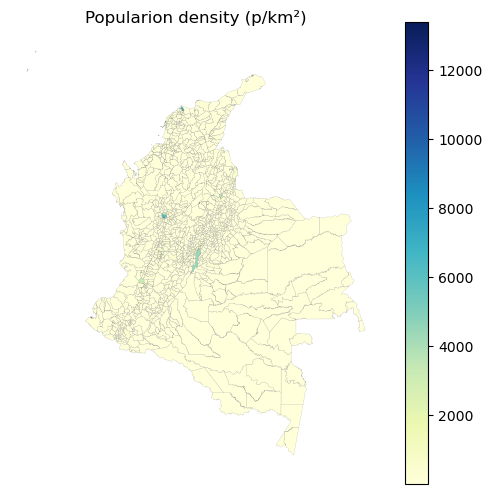

In [169]:
ax = muni.plot(column='pop_density_p_km2', cmap='YlGnBu', figsize=(6,6),
                     legend=True, edgecolor='grey', linewidth=0.1)
ax.set_title('Popularion density (p/km²)')
ax.set_axis_off()
plt.show()

### 2.4  Spatial predicates  

We can test spatial relationships such as *contains* and *intersects*.  
The cell below creates a Shapely `Point` for Bolívar Square (Bogotá) in EPSG 4326, reprojects it to EPSG 3116, and finds the municipality that **contains** it.

In [79]:
from shapely.geometry import Point
bolivar = gpd.GeoSeries(
    [Point(-74.0760, 4.5981)], crs=4326).to_crs(3116)

mask = muni.contains(bolivar.iloc[0])
muni.loc[mask, ['MPIO_CNMBR', 'MPIO_CDPMP']]

,MPIO_CNMBR,MPIO_CDPMP
908,"BOGOTÁ, D.C.",11001


### 2.5  Buffering & intersection  

The next cell builds a **10 km buffer** around Bolívar Square and selects municipalities that intersect that buffer, then plots the result.

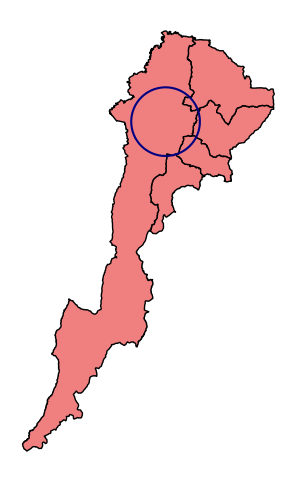

In [81]:
buffer_10km = bolivar.buffer(10_000)   # metres
sel = muni[muni.intersects(buffer_10km.unary_union)]

ax = sel.plot(facecolor='lightcoral', edgecolor='black', figsize=(6,6))
gpd.GeoSeries(buffer_10km).boundary.plot(ax=ax, color='navy')
ax.set_axis_off()
plt.show()

### 2.6  Overlay operations  

`geopandas.overlay()` performs geometric set operations.  
The next cell **clips** the selected municipalities by the 10 km buffer (intersection).

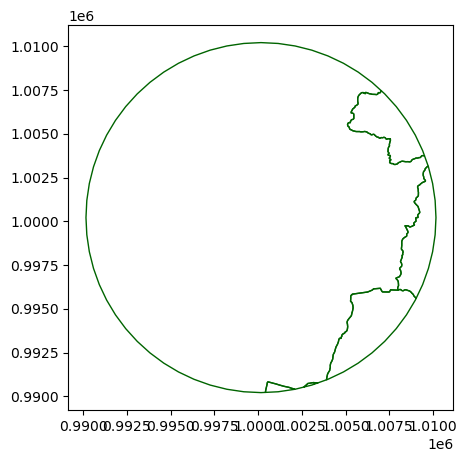

In [83]:
clipped = gpd.overlay(sel, gpd.GeoDataFrame(geometry=buffer_10km),
                        how='intersection')
clipped.plot(edgecolor='darkgreen', facecolor='none', figsize=(5,5))
plt.show()

### 2.7  Dissolving municipalities into departments  

Aggregating multiple geometries with `.dissolve()` produces multi‑polygon departments and summarises numeric attributes. Using a dictionary in aggfunc lets us sum population and area, then recompute department-level density.

In [174]:
dptos = muni.dissolve(
    by='DPTO_CCDGO',
    aggfunc={'area_km2': 'sum', 'STP27_PERS': 'sum'}
)
dptos['pop_density'] = dptos['STP27_PERS'] / dptos['area_km2']
dptos

,geometry,area_km2,STP27_PERS,pop_density
DPTO_CCDGO,,,,
05,"POLYGON ((797311.153 1098218.268, 797296.716 1...",62804.708984,5974788.0,95.132803
08,"POLYGON ((913344.747 1635351.841, 913045.460 1...",3315.752105,2342265.0,706.405342
11,"POLYGON ((1000367.810 1026577.849, 1000387.771...",1622.852605,7181469.0,4425.213343
13,"MULTIPOLYGON (((769570.062 1530592.901, 769491...",26719.196397,1909460.0,71.463976
15,"POLYGON ((1069888.018 1032371.020, 1069844.914...",23138.048132,1135698.0,49.083570
17,"POLYGON ((860203.953 1049730.409, 860229.936 1...",7425.221672,923472.0,124.369620
18,"POLYGON ((843380.042 578391.001, 843334.602 57...",90103.008160,359602.0,3.991010
19,"POLYGON ((671667.322 681452.757, 671665.984 68...",31242.914795,1243503.0,39.801120
20,"POLYGON ((1076018.853 1388756.407, 1076065.315...",22562.344407,1098577.0,48.690729


#### Now it’s your turn #2 – Spatial data exercises  

1. Select and map **three** municipalities whose centroid lies west of 75° W longitude.  
2. Compute the *perimeter : area* ratio for every municipality and identify the most compact one.  
3. Draw a 10 km buffer around a municipality of your choice and highlight intersecting neighbours.
4. “Calculate and map the percentage of dwellings with internet


---

## 3  Attribute operations  
(If yo uwant to go further check **[This LINK](https://py.geocompx.org/02-attribute-operations.html)**)  
All 80 census variables are numeric counts, so they behave like ordinary pandas columns: you can add, divide, group, and classify them. See the manual for categorical meanings.


### 3.1  Column selection and boolean indexing  

The cell below keeps only selected columns and filters municipalities larger than 1 000 km².

In [184]:
core = muni[['DPTO_CCDGO', 'MPIO_CNMBR', 'area_km2']]
large = core[core.area_km2 > 1000].sort_values('area_km2', ascending=False)
large.head()

,DPTO_CCDGO,MPIO_CNMBR,area_km2
188,99,CUMARIBO,65597.212445
12,18,SOLANO,42312.783610
187,99,LA PRIMAVERA,18362.896666
11,18,SAN VICENTE DEL CAGUÁN,17464.634368
937,50,PUERTO GAITÁN,17250.083167


Show municipalities where < 30 % of dwellings have internet.

In [188]:
poor_net = muni[
    (muni['STP19_INT1'] / muni['STVIVIENDA']) < 0.3
][['MPIO_CNMBR', 'DPTO_CCDGO']]
poor_net.head()


,MPIO_CNMBR,DPTO_CCDGO
0,FLORENCIA,18
1,ALBANIA,18
2,BELÉN DE LOS ANDAQUÍES,18
3,EL DONCELLO,18
4,EL PAUJÍL,18


### 3.2  Creating new attributes  

We next classify municipal area into quartiles using `pd.qcut()`.

In [101]:
muni['area_class'] = pd.qcut(muni.area_km2, 4,
                             labels=['Q1','Q2','Q3','Q4'])
muni['area_class'].value_counts()

area_class
Q1    281
Q4    281
Q2    280
Q3    280
Name: count, dtype: int64

### 3.3  Grouping and summarising  

The following cell sums total municipal area by department and shows the five largest.

In [105]:
area_by_dpto = muni.groupby('DPTO_CCDGO')['area_km2'].sum()                      .sort_values(ascending=False)
area_by_dpto.head()

DPTO_CCDGO
91    109497.053810
99    100063.370746
18     90103.008160
50     85527.289734
94     71289.354694
Name: area_km2, dtype: float64

Computes the departmental share of households in ethnic territories.

In [193]:
ethnic_share = (
    muni.groupby('DPTO_CCDGO')['STP3_1_SI'].sum()
    / muni.groupby('DPTO_CCDGO')['STCTNENCUE'].sum()
    * 100
)
ethnic_share.sort_values(ascending=False).head()


DPTO_CCDGO
97    54.095904
27    34.801234
94    28.141512
44    27.811409
99    27.573751
dtype: float64

### 3.4  Joining a non‑spatial table  

We load the agricultural CSV, rename the municipality code column, and perform a **left join** onto the GeoDataFrame. This enriches the spatial layer with production information.

In [156]:
eva = pd.read_csv(csv_path, encoding='latin1')

#TRy also this one
eva = pd.read_csv(csv_path, encoding='utf-8')

eva = eva.rename(columns={'CÓD. MUN.': 'MPIO'})
print(eva.head())
eva['MPIO'] = eva['MPIO'].astype(str).str.zfill(5)
muni['MPIO_CDPMP'] = muni['MPIO_CDPMP'].astype(str).str.zfill(5)

muni_eva = muni.merge(
    eva,
    how='left',                 # left = muni
    left_on='MPIO_CDPMP',       # key in en muni
    right_on='MPIO',            # key in eva
    indicator=True,             # create  column _merge
    validate='one_to_many',      # or 'one_to_many' check all the possibilities
    suffixes=('', '_eva')       # evita colisiones de nombre
)
print(muni_eva['_merge'].value_counts())
print(muni_eva.columns.tolist())

   CÓD. \nDEP.        DEPARTAMENTO   MPIO   MUNICIPIO GRUPO \nDE CULTIVO  \
0           15              BOYACA  15114    BUSBANZA         HORTALIZAS   
1           25        CUNDINAMARCA  25754      SOACHA         HORTALIZAS   
2           25        CUNDINAMARCA  25214        COTA         HORTALIZAS   
3           54  NORTE DE SANTANDER  54405  LOS PATIOS         HORTALIZAS   
4           54  NORTE DE SANTANDER  54518    PAMPLONA         HORTALIZAS   

  SUBGRUPO \nDE CULTIVO CULTIVO DESAGREGACIÓN REGIONAL Y/O SISTEMA PRODUCTIVO  \
0                ACELGA  ACELGA                                        ACELGA   
1                ACELGA  ACELGA                                        ACELGA   
2                ACELGA  ACELGA                                        ACELGA   
3                ACELGA  ACELGA                                        ACELGA   
4                ACELGA  ACELGA                                        ACELGA   

    AÑO PERIODO  Área Sembrada\n(ha)  Área Cosechada\n(h

The next cell derives **rice yield** (t ha⁻¹) and maps it using a quantile scheme and the `PuRd` colour map.

['DPTO_CCDGO', 'MPIO_CCDGO', 'MPIO_CNMBR', 'MPIO_CDPMP', 'VERSION', 'AREA', 'LATITUD', 'LONGITUD', 'STCTNENCUE', 'STP3_1_SI', 'STP3_2_NO', 'STP3A_RI', 'STP3B_TCN', 'STP4_1_SI', 'STP4_2_NO', 'STP9_1_USO', 'STP9_2_USO', 'STP9_3_USO', 'STP9_4_USO', 'STP9_2_1_M', 'STP9_2_2_M', 'STP9_2_3_M', 'STP9_2_4_M', 'STP9_2_9_M', 'STP9_3_1_N', 'STP9_3_2_N', 'STP9_3_3_N', 'STP9_3_4_N', 'STP9_3_5_N', 'STP9_3_6_N', 'STP9_3_7_N', 'STP9_3_8_N', 'STP9_3_9_N', 'STP9_3_10', 'STP9_3_99', 'STVIVIENDA', 'STP14_1_TI', 'STP14_2_TI', 'STP14_3_TI', 'STP14_4_TI', 'STP14_5_TI', 'STP14_6_TI', 'STP15_1_OC', 'STP15_2_OC', 'STP15_3_OC', 'STP15_4_OC', 'TSP16_HOG', 'STP19_EC_1', 'STP19_ES_2', 'STP19_EE_1', 'STP19_EE_2', 'STP19_EE_3', 'STP19_EE_4', 'STP19_EE_5', 'STP19_EE_6', 'STP19_EE_9', 'STP19_ACU1', 'STP19_ACU2', 'STP19_ALC1', 'STP19_ALC2', 'STP19_GAS1', 'STP19_GAS2', 'STP19_GAS9', 'STP19_REC1', 'STP19_REC2', 'STP19_INT1', 'STP19_INT2', 'STP19_INT9', 'STP27_PERS', 'STPERSON_L', 'STPERSON_S', 'STP32_1_SE', 'STP32_2_SE', '

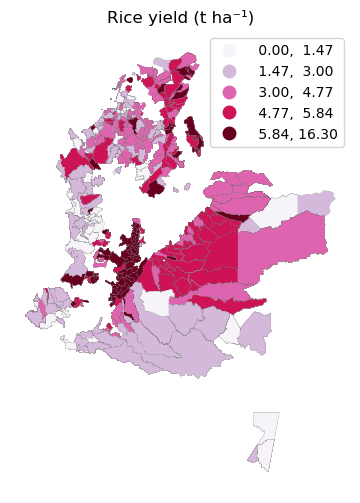

In [231]:
rice = muni_eva[muni_eva['CULTIVO'] == 'ARROZ'].copy()
print(muni_eva.columns.tolist())
rice['yield_t_ha'] = rice['Producción\n(t)'] / rice['Área Sembrada\n(ha)']
rice_map = rice.dropna(subset=['yield_t_ha'])

ax = rice_map.plot(column='yield_t_ha', scheme='Quantiles', k=5,
                   cmap='PuRd', legend=True,
                   figsize=(6,6), edgecolor='grey', linewidth=0.1)
ax.set_title('Rice yield (t ha⁻¹)')
ax.set_axis_off()
plt.show()

#### Now it’s your turn #3 – Attribute drills  

1. Create a bar chart of the **top‑10** municipalities by *maize* production.  
2. Map coffee yield and describe spatial trends you observe.  
3. Calculate the mean municipal area per *ZONA* category.
4. Map the proportion of dwellings connected to gas: STP19_GAS1 / STVIVIENDA.
5. Compute the sex ratio (STP32_1_SE / STP32_2_SE) for every municipality and discuss spatial patterns.


---

## 4  Visualisation best practice  

Choose an equal‑area CRS, add clear legends, north arrows, and cite data sources.  
The next cell reprojects the rice yield map to **Web Mercator (EPSG 3857)**, adds a basemap, and annotates the source line.

In [234]:
ax = rice_map.to_crs(9377).plot(column='yield_t_ha', cmap='YlGn',
                     figsize=(8,8), edgecolor='black', linewidth=0.1, legend=True)
cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager)
ax.set_title('Rice yield by municipality – Colombia')
ax.annotate('Data: EVA 2023; Boundaries: IGAC', xy=(0.02, 0.05),
            xycoords='axes fraction', fontsize=9)
ax.set_axis_off()
plt.show()

GEOSException: bad allocation

#### Now it’s your turn #4 – Cartography challenge  

* Re‑project to the CRS 4326.  
* Add grey department boundaries on top.  
* Compose a concise caption in British English that explains what the map shows.  


---

## 5  Key take‑aways  

* `GeoDataFrame` = pandas DataFrame + GeoSeries of Shapely geometries.  
* EPSG 3116 is **metric**, so distance/area outputs are meaningful.  
* Attribute joins and spatial overlays enrich your data for analysis.  
* Clear cartographic choices aid interpretation.  

Next up: **Raster data & raster‑vector interactions** (see *Geocomputation with Python* Chapter 3).  
